# March Madness and Analytics:

## Can you Predict NCAA Basketball Tournament Bids from the Massey Ratings?

In another notebook, we looked at the correlation between tournament bids for men's and women's NCAA D-1 basketball teams.  We used data for rankings that were based on the [Massey Ratings](https://www.masseyratings.com).  In this notebook we try to understand the relationship between the Massey Rating and the likelihood that a team get a tournament bid. However, we want to approach this as a machine learning problem, not just as a problem in descriptive statistics.

This process is like any machine learning project in which you need to predict a binary outcome from a numeric variable (frequently a continuous variable).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from numpy import random
# Set the seed if you want to get the same results from run to run.
# random.seed(2021)

In [3]:
coin_flip = "heads" if random.rand()<0.5 else "tails"

if coin_flip == "heads":
    gender = "men"
else:
    gender = "women"

print(f' Coin flip is {coin_flip}: {gender.title()}')

 Coin flip is tails: Women


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

I downloaded Massey Ratings to the csv files `Massey_men_d1.csv` and `Massey_women_d1.csv` 
from [here](https://www.masseyratings.com/cb/ncaa-d1/ratings) for the men and
from [here](https://www.masseyratings.com/cbw/ncaa-d1/ratings) for the women. The *rating* is a continuous 
numerical variable, and it is accompanied by a *ranking* according to those values. You can read on the Massey Ratings site how they derive the ratings. In the other notebook, on Kendall's Tau, we primarily analyzed ranking. In this notebook we focus on the rating, but this entire analysis could be done using ranking as the numeric variable.

In [5]:
df_inspect = pd.read_csv(f'Massey_{gender}_d1.csv')

In [6]:
df_inspect.head()

,Team,Unnamed: 1,Record,Unnamed: 3,&Delta;,Rat,Unnamed: 6,Pwr,Unnamed: 8,Off,Unnamed: 10,Def,Unnamed: 12,HFA,SoS,Unnamed: 15,SSF,Unnamed: 17,EW,EL
0,Connecticut,Big East,26-1,0.963,1.0,1,9.59,1,78.02,3,104.72,1,38.19,2.65,69,48.34,66,48.83,8.400000e-01,0.16
1,Stanford,Pac 12,27-2,0.931,-1.0,2,9.41,3,76.40,6,104.24,2,37.05,2.70,20,54.09,22,54.09,-4.440892e-16,0.00
2,Baylor,Big 12,27-2,0.931,NaN,3,9.27,2,76.55,4,104.45,3,36.98,2.78,60,49.64,56,50.10,8.300000e-01,0.17
3,Maryland,Big 10,26-2,0.929,NaN,4,9.20,4,75.07,1,112.57,40,27.39,2.82,33,52.48,34,52.48,0.000000e+00,0.00
4,South Carolina,Southeastern,24-4,0.857,NaN,5,8.67,5,70.06,10,99.86,5,35.09,2.76,14,54.61,15,54.63,9.000000e-01,0.10


In [7]:
use_cols = ['Team', 'Unnamed: 1', 'Record', 'Unnamed: 3', 'Rat', 'Unnamed: 6']
col_types = [object,object,object,float,int,float]
dtype_map = dict(zip(use_cols,col_types))

col_map = {'Unnamed: 1':'Conference',
           'Record':'Record_winloss',
           'Unnamed: 3':'Record_pct',
           'Rat':'Ranking',
           'Unnamed: 6':'Massey_rating'}


In [8]:
df_ratings = pd.read_csv(f'Massey_{gender}_d1.csv', 
                              usecols=use_cols,
                              dtype=dtype_map,
                              index_col='Team').rename(columns=col_map)

In [9]:
df_ratings.sample(5).sort_values('Massey_rating')

,Conference,Record_winloss,Record_pct,Ranking,Massey_rating
Team,,,,,
Iona,Metro Atlantic,6-9,0.400,304,3.38
Southern Utah,Big Sky,11-9,0.550,208,4.68
UC Irvine,Big West,15-9,0.625,191,4.82
Wisconsin,Big 10,5-19,0.208,105,5.79
Tulane,American Athletic,18-9,0.667,72,6.30


In [10]:
df_ratings['Wins'] = df_ratings.Record_winloss.apply(lambda x: x.split('-')[0])
df_ratings['Losses'] = df_ratings.Record_winloss.apply(lambda x: x.split('-')[1])
df_ratings.drop('Record_winloss',axis=1,inplace=True)

In [11]:
df_ncaa_field = pd.read_csv(f'tournament_{gender}.csv')
df_ncaa_field['Tournament_bid'] = 1

In [12]:
df_ratings = df_ratings.merge(df_ncaa_field,on='Team',how='outer').fillna(0)

In [13]:
df_ratings.sample(5).sort_values('Massey_rating')

,Team,Conference,Record_pct,Ranking,Massey_rating,Wins,Losses,Tournament_bid
323,TAM C. Christi,Southland,0.316,323,3.16,6,13,0.0
282,Presbyterian,Big South,0.524,283,3.76,11,10,0.0
278,Vermont,America East,0.667,279,3.87,4,2,0.0
200,Cal Poly,Big West,0.542,201,4.73,13,11,0.0
104,Wisconsin,Big 10,0.208,105,5.79,5,19,0.0


In [14]:
df_ratings['Conf_rank'] = df_ratings.groupby('Conference').Massey_rating\
.rank(method='first',ascending=False)

In [15]:
df_bids = df_ratings.groupby('Conference')[['Tournament_bid']].sum()\
.rename(columns={'Tournament_bid':'Conf_bids'})
df_ratings = df_ratings.merge(df_bids, on='Conference')

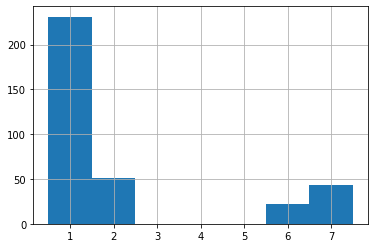

In [16]:
max_bids = int(df_ratings.Conf_bids.max().round(0))
df_ratings.Conf_bids.hist(bins=np.linspace(0.5,0.5+max_bids,max_bids+1));
plt.xticks(range(1,max_bids+1));

In [17]:
df_ratings['Power_conf'] = df_ratings['Conf_bids'].apply(lambda x: 0 if (x<=2) else 1)
df_ratings.drop('Conf_bids',axis=1,inplace=True)

# Reorder the columns.
df_ratings = df_ratings[['Team', 'Conference', 'Ranking', 'Massey_rating', 'Record_pct', 
                         'Wins', 'Losses', 'Conf_rank', 'Power_conf', 'Tournament_bid']]

In [18]:
df_ratings.groupby('Power_conf').Massey_rating.describe()

,count,mean,std,min,25%,50%,75%,max
Power_conf,,,,,,,,
0,290.0,4.616897,1.173986,1.27,3.765,4.655,5.3775,9.59
1,65.0,7.081846,0.942775,5.17,6.350,6.960,7.6900,9.41


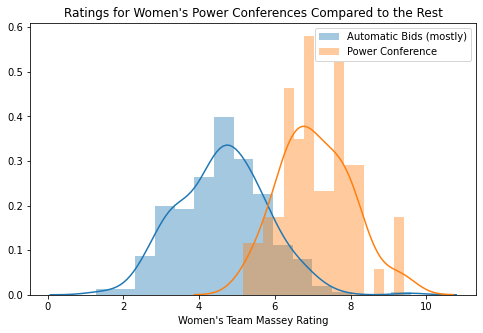

In [19]:
plt.figure(figsize=(8,5))
df_ratings.groupby('Power_conf').apply(lambda x: sns.distplot(x.Massey_rating,kde=True,bins=16));
plt.legend(['Automatic Bids (mostly)','Power Conference']);
plt.xlabel(f"{gender.title()}'s Team Massey Rating")
plt.title(f"Ratings for {gender.title()}'s Power Conferences Compared to the Rest");

## How do the ratings compare between the teams with and without tournament bids?

We start by just looking at some descriptive statistics using the `groupby` and `describe` methods.

In [20]:
df_ratings.groupby('Tournament_bid').Massey_rating.describe()

,count,mean,std,min,25%,50%,75%,max
Tournament_bid,,,,,,,,
0.0,291.0,4.657010,1.182970,1.27,3.7700,4.690,5.46,7.78
1.0,64.0,6.937969,1.253846,4.40,6.0775,7.095,7.71,9.59


For the men and women we see that mean ratings between the teams getting tournament bids and those who did not are fairly well separated. For the men the means differed by 1.70 points with standard deviations under 1.0. For the women the means were a little closer with a difference of 1.27 and standard deviations in the neighborhood of 1.2.

From a stats perspective, we can conduct a t-test for independent samples. Here we see that Student's t statistic is 13.4 for the women with a corresponding p-value that is extremely small at 2.7e-23. Results for the men are similar. See the documentation at [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for details.
(I have set the keyword argument `equal_var` to `False`, but we might reasonably be able to assume `True`.)

In [21]:
from scipy.stats import ttest_ind

In [22]:
teams_grouped = df_ratings.groupby('Tournament_bid')

a = np.array(teams_grouped.get_group(True).Massey_rating)
b = np.array(teams_grouped.get_group(False).Massey_rating)

ttest_ind(a,b,axis=0,equal_var=False)

Ttest_indResult(statistic=13.308810589315817, pvalue=6.481119227943e-23)

Here we plot histograms of the subgroups.

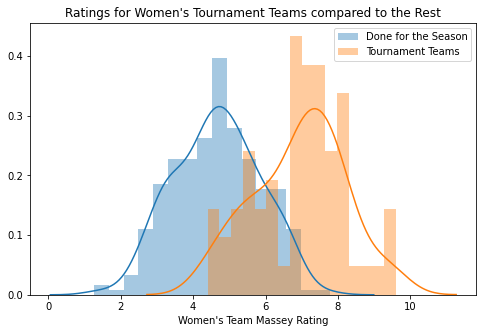

In [23]:
plt.figure(figsize=(8,5))
teams_grouped.apply(lambda x: sns.distplot(x.Massey_rating,kde=True,bins=16));
plt.legend(['Done for the Season','Tournament Teams']);
plt.xlabel(f"{gender.title()}'s Team Massey Rating")
plt.title(f"Ratings for {gender.title()}'s Tournament Teams compared to the Rest");

## Machine Learning Models

Now we are ready to look at some machine learning models.  Let's start with some tree-based models.  A decision tree is an easy model to understand. We will use the Scikit-learn decision tree whic is documented [here.](https://scikit-learn.org/stable/modules/tree.html)  

Let's consider the general case where the target variable y is a categorical variable atking one of $n$ values. Let the probability that y is i be denoted by $P(y = i) = p_i,$ for $1 \le i \le n.$ The *Gini impurity* is defined to be the $\frac{1}{N}\sum_{j=1}^N p_i*(1-p_i)$ where the jth observation $y_j = i$.  An alternative to Gini impurity is *entropy* which is $\frac{-1}{N} \sum_{i=1}^N p_i  \log(p_i).$  For each variable, $x_i,$ you look at a list of potential cut points, $c_j,$ and divide the data into two subsets one where $x_i \le  c_j$ and its complement. Compute the impurity (entropy) of the resulting two subsets.  Have you reduced the overall impurity (entropy)?  Choose the variable and cut point that reduces it most.

This gives us the basis for a recursive method. We start with one big dataset, and we divide it. We think of the original dataset as the trunk of a tree, and the subsets are each one branch (also called nodes). For each subset of the data, we do the same thing. Dividing the subsets of the data and creating more branches.

How do we stop? You can keep dividing the nodes until you reach individual observations, or you can impose some rules.  For example, you might limit the depth of the tree, or you might only consider splits that actually decrease the impurity (entropy). You might set a minimum size for each subset of data, refusing to split any node if one of the resulting nodes is two small. A terminal node is called a *leaf*.  Assign to each leaf the most prevalent category of the observations at the leaf.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [25]:
feature_set = ['Record_pct', 'Ranking', 'Wins', 'Losses', 'Conf_rank', 'Power_conf']
target_set = ['Tournament_bid']

X = np.array(df_ratings[feature_set]).reshape(-1,len(feature_set))
y = np.array(df_ratings[target_set]).reshape(-1,len(target_set))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

decision_tree_clf = DecisionTreeClassifier(criterion='entropy',
                                           random_state=42,
                                           max_depth=4,
                                           min_samples_leaf=3,
                                           min_impurity_decrease=0.01)
decision_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4,
                       min_impurity_decrease=0.01, min_samples_leaf=3,
                       random_state=42)

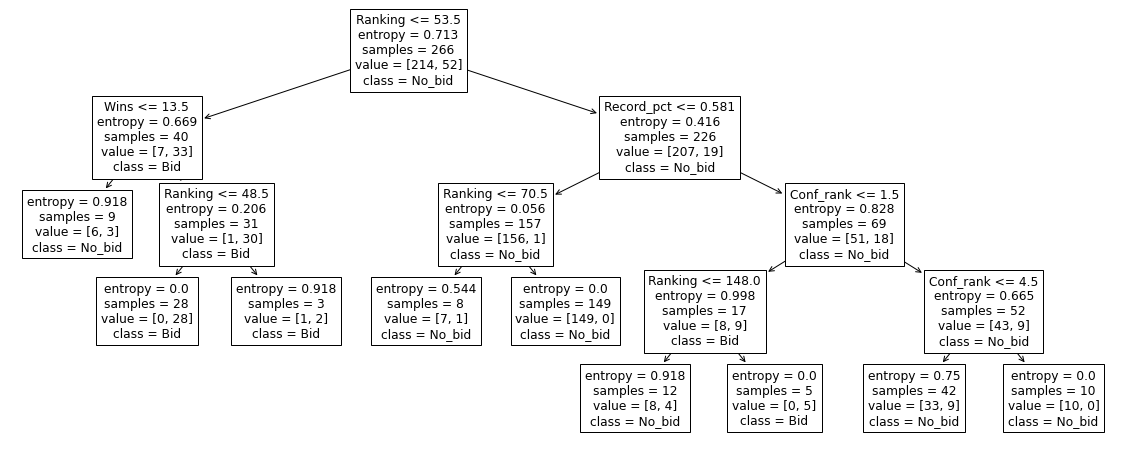

In [26]:
plt.figure(figsize=(20,8))
tree.plot_tree(decision_tree_clf,
               feature_names=feature_set,
               class_names=['No_bid','Bid']);


The score for the model is the accuracy of the calssification.

In [27]:
decision_tree_clf.score(X_test,y_test)

0.9325842696629213

In [28]:
# clf.get_params()

Let's look at how the model predicts outcomes.  Below we take a sample of the full dataset which will include a combination of training and test data, but it gives an idea of what the predicted outcome looks like.

In [29]:
# We want to sample equally from tournament and non-tournament teams.
my_group = df_ratings.groupby('Tournament_bid')
df_sample = pd.concat([my_group.get_group(g).sample(8) for g in my_group.groups],axis=0)
# df_full = df_ratings.copy()

X_sample = np.array(df_sample[feature_set]).reshape(-1,len(feature_set))
# X_full = np.array(df_full[feature_set]).reshape(-1,len(feature_set))

df_sample['Model_prediction'] = decision_tree_clf.predict(X_sample)
# df_full['Model_prediction'] = decision_tree_clf.predict(X_full)

df_sample.sort_values('Ranking',ascending=True)
# df_full[df_full.Conference=='Big 10'].sort_values('Record_pct',ascending=False)

,Team,Conference,Ranking,Massey_rating,Record_pct,Wins,Losses,Conf_rank,Power_conf,Tournament_bid,Model_prediction
23,Baylor,Big 12,3,9.27,0.931,27,2,1.0,1,1.0,1.0
25,Texas,Big 12,21,7.64,0.690,20,9,3.0,1,1.0,1.0
40,Michigan St,Big 10,29,7.30,0.625,15,9,8.0,1,1.0,1.0
53,Alabama,Southeastern,35,7.09,0.630,17,10,7.0,1,1.0,1.0
67,North Carolina,Atlantic Coast,44,6.86,0.542,13,11,7.0,1,1.0,0.0
4,DePaul,Big East,58,6.57,0.583,14,10,5.0,0,0.0,0.0
194,Idaho St,Big Sky,82,6.17,0.846,22,4,1.0,0,1.0,0.0
147,MTSU,Conference USA,112,5.70,0.680,17,8,2.0,0,1.0,0.0
46,Illinois,Big 10,116,5.63,0.217,5,18,14.0,1,0.0,0.0
209,Ball St,Mid-American,125,5.51,0.560,14,11,5.0,0,0.0,0.0


## Generalizing the Model: Random Forests

The tree above was trained on a particular training set. It could be underfitting or overfitting the data. We can construct a number of slightly different trees by taking a random sample of the row amnd columns before fitting a decision tree to it.  Below we have several trees constructed from these subsets of the data.

Features: Record_pct, Conf_rank, Ranking, Wins
Accuracy: 0.921


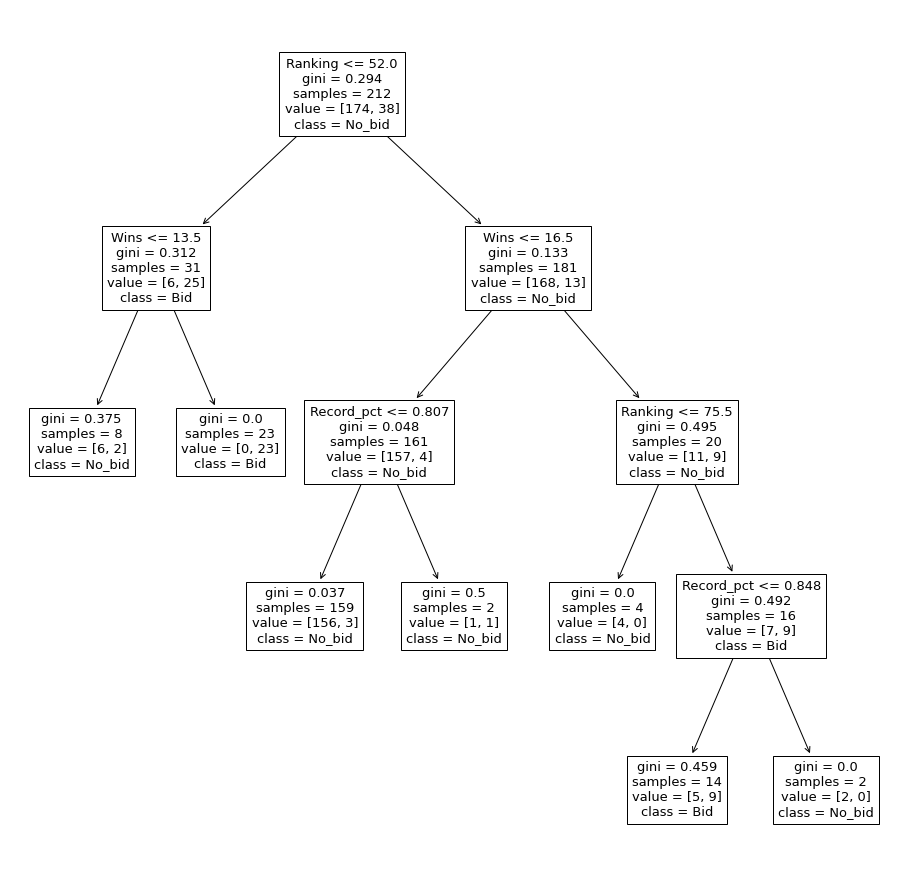

In [30]:
random_features = list(random.choice(feature_set,4,replace=False))
target_set = ['Tournament_bid']
print("Features: " + ', '.join(random_features))
num_rows,num_cols = X_train.shape
random_rows = np.sort(random.choice(np.arange(num_rows),int(num_rows*0.8),replace=False))
random_cols = np.sort(random.choice(np.arange(num_cols),int(num_cols*0.8),replace=False))

clf_rand = DecisionTreeClassifier(random_state=42,
                             max_depth=4,
                             min_samples_leaf=2,
                             min_impurity_decrease=.004)
clf_rand.fit(X_train[list(random_rows),:][:,list(random_cols)], y_train[list(random_rows)])

plt.figure(figsize=(16,16))
tree.plot_tree(clf_rand,
              feature_names=[feature_set[i] for i in random_cols],
               class_names=['No_bid','Bid']);

print(f'Accuracy: {clf_rand.score(X_test[:,random_cols],y_test):.3f}')

Features: Losses, Ranking, Power_conf, Conf_rank
Accuracy: 0.944


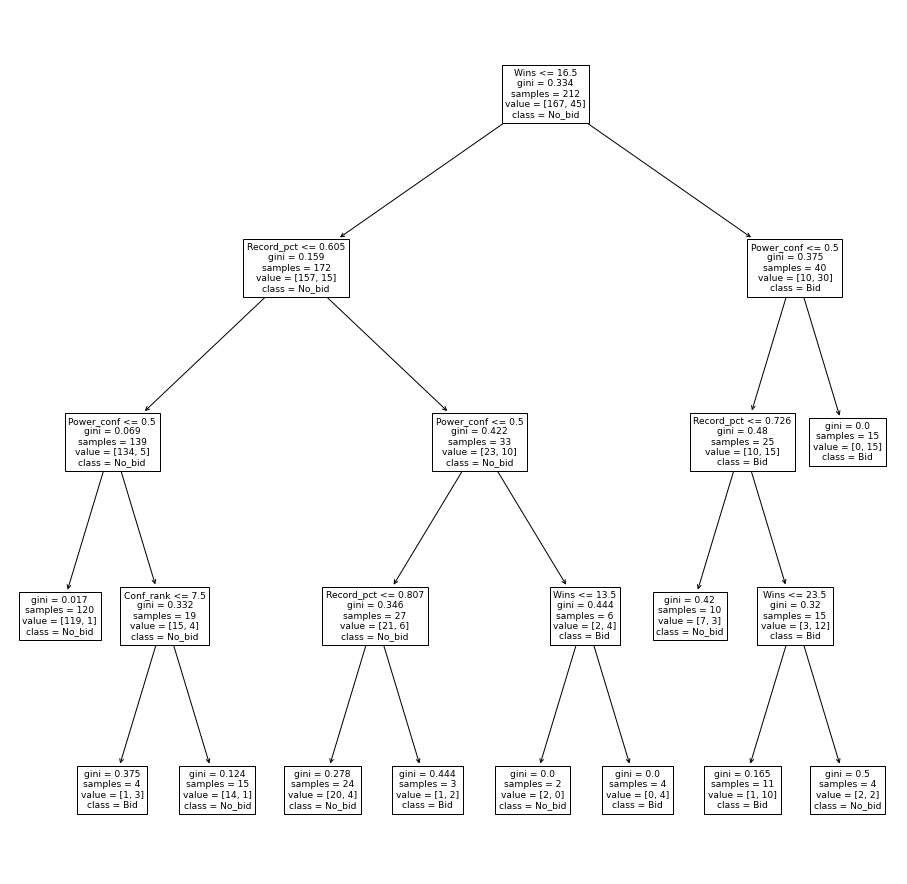

In [31]:
random_features = list(random.choice(feature_set,4,replace=False))
target_set = ['Tournament_bid']
print("Features: " + ', '.join(random_features))
num_rows,num_cols = X_train.shape
random_rows = np.sort(random.choice(np.arange(num_rows),int(num_rows*0.8),replace=False))
random_cols = np.sort(random.choice(np.arange(num_cols),int(num_cols*0.8),replace=False))

clf_rand = DecisionTreeClassifier(random_state=42,
                             max_depth=4,
                             min_samples_leaf=2,
                             min_impurity_decrease=.004)
clf_rand.fit(X_train[list(random_rows),:][:,list(random_cols)], y_train[list(random_rows)])

plt.figure(figsize=(16,16))
tree.plot_tree(clf_rand,
              feature_names=[feature_set[i] for i in random_cols],
               class_names=['No_bid','Bid']);

print(f'Accuracy: {clf_rand.score(X_test[:,random_cols],y_test):.3f}')

Features: Conf_rank, Wins, Record_pct, Ranking
Accuracy: 0.921


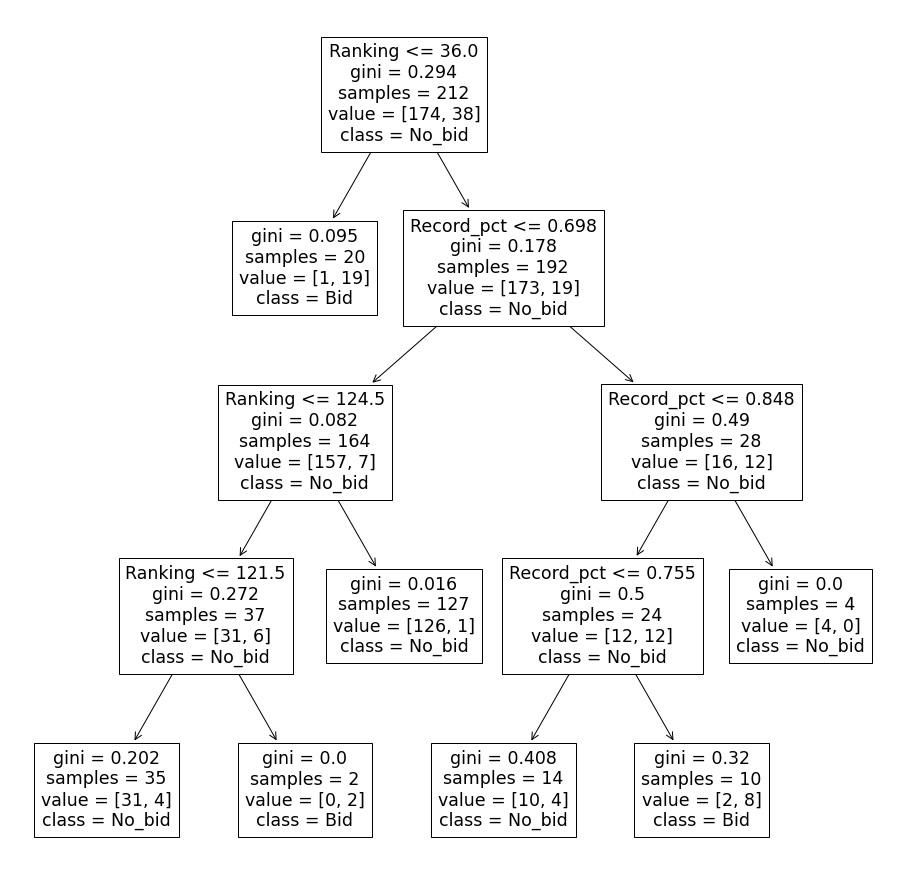

In [32]:
random_features = list(random.choice(feature_set,4,replace=False))
target_set = ['Tournament_bid']
print("Features: " + ', '.join(random_features))
num_rows,num_cols = X_train.shape
random_rows = np.sort(random.choice(np.arange(num_rows),int(num_rows*0.8),replace=False))
random_cols = np.sort(random.choice(np.arange(num_cols),int(num_cols*0.8),replace=False))

clf_rand = DecisionTreeClassifier(random_state=42,
                             max_depth=4,
                             min_samples_leaf=2,
                             min_impurity_decrease=.004)
clf_rand.fit(X_train[list(random_rows),:][:,list(random_cols)], y_train[list(random_rows)])

plt.figure(figsize=(16,16))
tree.plot_tree(clf_rand,
              feature_names=[feature_set[i] for i in random_cols],
               class_names=['No_bid','Bid']);

print(f'Accuracy: {clf_rand.score(X_test[:,random_cols],y_test):.3f}')

### The Random Forest

We have shown how to construct multiple *random trees*, now we need to construct and *ensemble model* that combines the results all of the random trees.  For a random forest classifier, we take the results of all of the trees on a single observation and assign the most common classification; i.e. the trees "vote" on the classification.  For a regression model, the results of the trees can be averaged.

Perhaps the biggest asset of a decision tree is the visual explanation of the rules applied to reach a decsion. Unfortunately, with a random forest we no longer have that simple visual display. It's a black box.

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
random_forest_clf = RandomForestClassifier(random_state=42,
                                           max_depth=3)
random_forest_clf.fit(X_train, y_train.ravel())
random_forest_clf.score(X_test,y_test.ravel())

0.9550561797752809

Now when we apply the random forest classifier to a sample of the data, we have a classification and a probability.  The latter is an estimate of the likelihood that we have classified the observation correctly.  These are not true probabilities, but they 

In [35]:
# We want to sample equally from tournament and non-tournament teams.
my_group = df_ratings.groupby('Tournament_bid')
df_sample = pd.concat([my_group.get_group(g).sample(8) for g in my_group.groups],axis=0)

X_sample = np.array(df_sample[feature_set]).reshape(-1,len(feature_set))
df_sample['Model_probability'] = random_forest_clf.predict_proba(X_sample)[:,1]
df_sample['Model_prediction'] = random_forest_clf.predict(X_sample)

df_sample.sort_values('Model_probability',ascending=False)

,Team,Conference,Ranking,Massey_rating,Record_pct,Wins,Losses,Conf_rank,Power_conf,Tournament_bid,Model_probability,Model_prediction
62,Louisville,Atlantic Coast,10,8.15,0.893,25,3,2.0,1,1.0,0.969313,1.0
53,Alabama,Southeastern,35,7.09,0.630,17,10,7.0,1,1.0,0.837389,1.0
116,FL Gulf Coast,Atlantic Sun,51,6.76,0.897,26,3,1.0,0,1.0,0.818950,1.0
65,Syracuse,Atlantic Coast,36,7.07,0.625,15,9,5.0,1,1.0,0.688246,1.0
334,High Point,Big South,230,4.48,0.759,22,7,1.0,0,1.0,0.620748,1.0
16,Washington St,Pac 12,32,7.13,0.500,12,12,6.0,1,1.0,0.496305,0.0
67,North Carolina,Atlantic Coast,44,6.86,0.542,13,11,7.0,1,1.0,0.437744,0.0
221,Fordham,Atlantic 10,130,5.45,0.667,12,6,5.0,0,0.0,0.106618,0.0
72,Clemson,Atlantic Coast,71,6.33,0.462,12,14,12.0,1,0.0,0.091923,0.0
244,Wyoming,Mountain West,122,5.55,0.583,14,10,4.0,0,1.0,0.080151,0.0


### ROC Curves for Models
A nice feature from scikit-learn is the ability to plot a ROC curve from the estimator.  Note that the random forest usually outperforms the simple decision tree.

In [36]:
from sklearn.metrics import plot_roc_curve

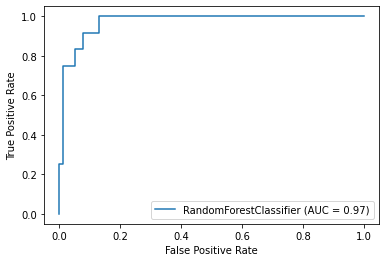

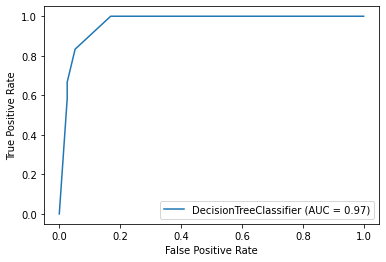

In [37]:
plot_roc_curve(random_forest_clf, X_test, y_test.ravel());
plot_roc_curve(decision_tree_clf, X_test, y_test.ravel());